# DSSATTools Example 3: paralel simulations using threading

In this notebook you'll see the basic usage of DSSATools library to:
1. Create the inputs
2. Initialize the simulation environment
3. Run simulations in paralel
4. Modify input objects
5. Read outputs.

We'll use threading to run simulations in paralel. If you prefer to use Multiprocessing, i.e. different cores, the process is different since multiprocessing does not allows the modification of an instance.

In [1]:
from DSSATTools import (
    Crop, SoilProfile, WeatherData, WeatherStation,
    Management, DSSAT
)
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import threading
import os
from matplotlib import pyplot as plt

## Create a WeatherData instance

In [2]:
# Random weather data
DATES = pd.date_range('2000-01-01', '2001-12-31')
N = len(DATES)
df = pd.DataFrame(
    {
    'tn': np.random.gamma(15, 1, N),
    'rad': np.random.gamma(10, 1.5, N),
    'prec': [0.0]* N,
    'rh': 100 * np.random.beta(1.5, 1.15, N),
    },
    index=DATES,
)
df['TMAX'] = df.tn + abs(np.random.normal(5, 10, N))
df.head()

,tn,rad,prec,rh,TMAX
2000-01-01,21.978468,16.796727,0.0,70.801918,31.923668
2000-01-02,14.194510,16.442578,0.0,22.941154,22.188152
2000-01-03,14.173361,9.534252,0.0,82.296923,17.259369
2000-01-04,25.762443,9.209921,0.0,57.205248,30.995471
2000-01-05,12.410814,14.233960,0.0,69.001627,15.298904


In [3]:
# Create a WeatherData instance
WTH_DATA = WeatherData(
    df,
    variables={
        'tn': 'TMIN', 'TMAX': 'TMAX',
        'prec': 'RAIN', 'rad': 'SRAD',
        'rh': 'RHUM'
    }
)
# Create a WheaterStation instance
wth = WeatherStation(
    WTH_DATA, 
    {'ELEV': 33, 'LAT': 0, 'LON': 0, 'INSI': 'test'}
)

## Create a SoilProfile object from a default profile

In [4]:
# Soil instance from default soil profile
soil = SoilProfile(default_class='SICL')

## Create a Crop object from default crop file

In [5]:
# Crop
crop = Crop('sorghum')
# Check how the cultivar looks like
crop.cultivar['IB0001']

{'VAR-NAME........': 'RIO',
 'EXPNO': '.',
 'ECO#': 'IB0001',
 'P1': 430.0,
 'P2': 102.0,
 'P2O': 11.6,
 'P2R': 24.0,
 'PANTH': 617.5,
 'P3': 152.5,
 'P4': 81.5,
 'P5': 540.0,
 'PHINT': 49.0,
 'G1': 0.0,
 'G2': 6.0,
 'PBASE': None,
 'PSAT': None}

## Initialize one DSSAT instance per thread

In [6]:
dssat_envs = []
threads = 8
for n in range(threads):
    dssat_envs.append(DSSAT())
    dssat_envs[-1].setup()

C:\Users\FS\AppData\Local\Temp\dssatqtsjnvuq created.
Static files copied to C:\Users\FS\AppData\Local\Temp\dssatqtsjnvuq.
C:\Users\FS\AppData\Local\Temp\dssatlsttrlvr created.
Static files copied to C:\Users\FS\AppData\Local\Temp\dssatlsttrlvr.
C:\Users\FS\AppData\Local\Temp\dssateowvnayl created.
Static files copied to C:\Users\FS\AppData\Local\Temp\dssateowvnayl.
C:\Users\FS\AppData\Local\Temp\dssatrpirrzsr created.
Static files copied to C:\Users\FS\AppData\Local\Temp\dssatrpirrzsr.
C:\Users\FS\AppData\Local\Temp\dssatxdcqbriw created.
Static files copied to C:\Users\FS\AppData\Local\Temp\dssatxdcqbriw.
C:\Users\FS\AppData\Local\Temp\dssatrtyughxn created.
Static files copied to C:\Users\FS\AppData\Local\Temp\dssatrtyughxn.
C:\Users\FS\AppData\Local\Temp\dssativetrvgg created.
Static files copied to C:\Users\FS\AppData\Local\Temp\dssativetrvgg.
C:\Users\FS\AppData\Local\Temp\dssatqubrulrj created.
Static files copied to C:\Users\FS\AppData\Local\Temp\dssatqubrulrj.


## Run with different management

In [7]:
# We'll run one simulation per cultivar, so we need a cultivars' list
cultivars = list(crop.cultivar.keys())[6:20]

In [8]:
# Create a wrap funciton to run the model
def run_dssat(thread, man):
    dssat_envs[thread].run(
        crop=crop, weather=wth, management=man, soil=soil
    )

In [9]:
current_thread = 0
# processes list
processes = []
# A dict to map each core run to its cultivar
cultivar_maping = {thread: '' for thread in range(threads)}
output = {} # To save the outputs
for cultivar in cultivars:
    man = Management(
        cultivar=cultivar,
        planting_date=DATES[10],
        irrigation='A' # Automatic Irrigation
    )
    cultivar_maping[current_thread] = cultivar
    # Modify harvest to harvest when maturity is reached
    man.simulation_controls['HARVS'] = 'M'
    processes.append(
        threading.Thread(target=run_dssat, args=(current_thread, man))
    )
    processes[-1].start()
    current_thread += 1
    # Wait until all of the processes are finished
    if (current_thread == threads) or (cultivar == cultivars[-1]):
        for p in processes: p.join()
        for thread, cul in cultivar_maping.items():
            output[cul] = dssat_envs[thread].output['PlantGro']
        current_thread = 0
        processes = []

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 114 175 20295  8884     0   457   486   109     0   -99      0  123
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 105 166 19059  8621     0   455   462   131     0   -99      0  123
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 130 188 24042  9979     0   510   541   106     0   -99      0  122
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1 101 161 18695  8568     0   433   451   120     0   -99      0  123
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PE

In [10]:
# Close all of the DSSAT instances
for dssat in dssat_envs: dssat.close()

C:\Users\FS\AppData\Local\Temp\dssatqtsjnvuq and its content has been removed.
C:\Users\FS\AppData\Local\Temp\dssatlsttrlvr and its content has been removed.
C:\Users\FS\AppData\Local\Temp\dssateowvnayl and its content has been removed.
C:\Users\FS\AppData\Local\Temp\dssatrpirrzsr and its content has been removed.
C:\Users\FS\AppData\Local\Temp\dssatxdcqbriw and its content has been removed.
C:\Users\FS\AppData\Local\Temp\dssatrtyughxn and its content has been removed.
C:\Users\FS\AppData\Local\Temp\dssativetrvgg and its content has been removed.
C:\Users\FS\AppData\Local\Temp\dssatqubrulrj and its content has been removed.


## Check the results for the yield

Text(0, 0.5, 'Yield (Kg/ha)')

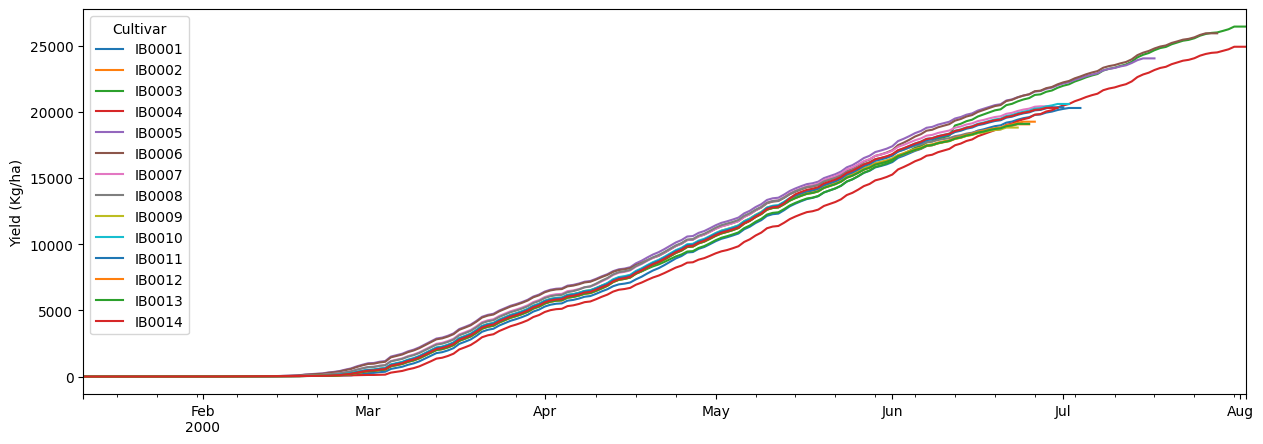

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
for cultivar, df in output.items():
    df.CWAD.plot(ax=ax, label=cultivar)
ax.legend(title='Cultivar')
ax.set_ylabel('Yield (Kg/ha)')